# Завдання

Використовуючи модель ARIMA і датасет Yearly sunspots data 1700-2008 побудуйте прогноз на 2009-2030 р.р.

# Розв'язок

In [3]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
data = sm.datasets.sunspots.load_pandas()
y = data.data
y['YEAR'] = pd.to_datetime(y['YEAR'], format='%Y')
y.index = y['YEAR']
del y['YEAR']
y

,SUNACTIVITY
YEAR,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0
...,...
2004-01-01,40.4
2005-01-01,29.8
2006-01-01,15.2


In [5]:
y = y['SUNACTIVITY'].resample('MS').mean()
y = y.fillna(y.bfill())                 
y

YEAR
1700-01-01     5.0
1700-02-01    11.0
1700-03-01    11.0
1700-04-01    11.0
1700-05-01    11.0
              ... 
2007-09-01     2.9
2007-10-01     2.9
2007-11-01     2.9
2007-12-01     2.9
2008-01-01     2.9
Freq: MS, Name: SUNACTIVITY, Length: 3697, dtype: float64

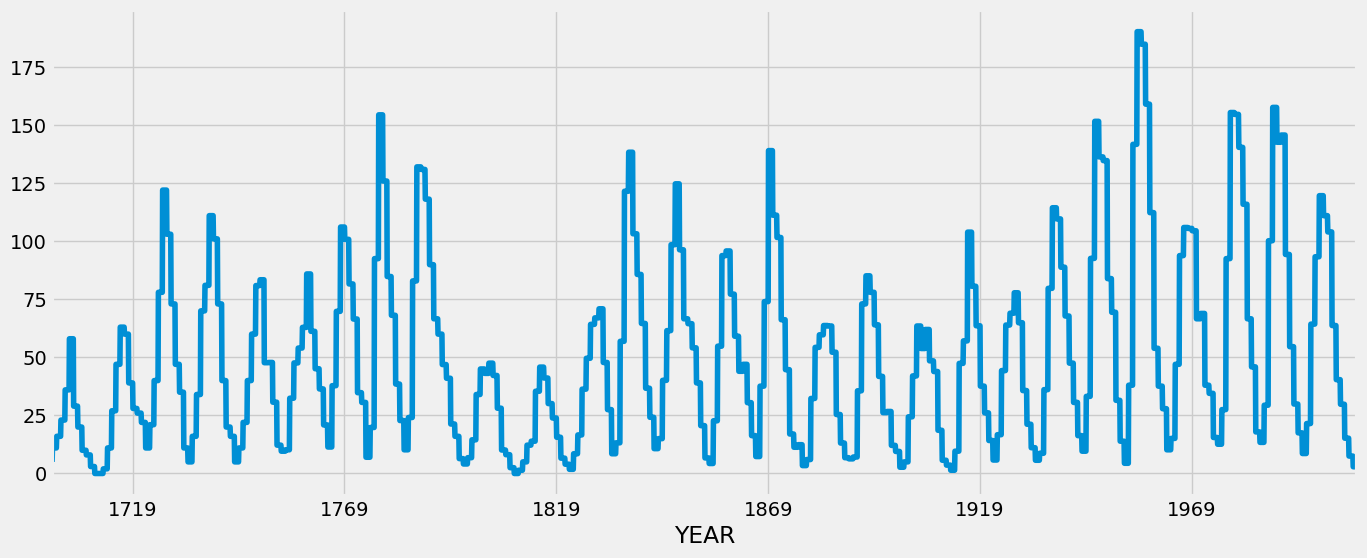

In [6]:
y.plot(figsize=(15, 6))
plt.show()

In [7]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 11) for x in list(itertools.product(p, d, q))] 

In [8]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}11 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 11)11 - AIC:41254.52731711659
ARIMA(0, 0, 0)x(0, 0, 1, 11)11 - AIC:37208.94660234073
ARIMA(0, 0, 0)x(0, 1, 0, 11)11 - AIC:33563.87561313526
ARIMA(0, 0, 0)x(0, 1, 1, 11)11 - AIC:32613.659640068283
ARIMA(0, 0, 0)x(1, 0, 0, 11)11 - AIC:33454.14126223984
ARIMA(0, 0, 0)x(1, 0, 1, 11)11 - AIC:32516.693219855402
ARIMA(0, 0, 0)x(1, 1, 0, 11)11 - AIC:32465.90285951856
ARIMA(0, 0, 0)x(1, 1, 1, 11)11 - AIC:32433.800820963042
ARIMA(0, 0, 1)x(0, 0, 0, 11)11 - AIC:36758.89703863916
ARIMA(0, 0, 1)x(0, 0, 1, 11)11 - AIC:33874.76846939934
ARIMA(0, 0, 1)x(0, 1, 0, 11)11 - AIC:30759.23937620975
ARIMA(0, 0, 1)x(0, 1, 1, 11)11 - AIC:30522.134835674646
ARIMA(0, 0, 1)x(1, 0, 0, 11)11 - AIC:30618.209329057958
ARIMA(0, 0, 1)x(1, 0, 1, 11)11 - AIC:30633.803359453384
ARIMA(0, 0, 1)x(1, 1, 0, 11)11 - AIC:30477.126684503815
ARIMA(0, 0, 1)x(1, 1, 1, 11)11 - AIC:30687.713653827537
ARIMA(0, 1, 0)x(0, 0, 0, 11)11 - AIC:24784.716026880404
ARIMA(0, 1, 0)x(0, 0, 1, 11)11 - AIC:24723.921592069146


In [9]:
# Кращий результат: ARIMA(1, 0, 1)x(0, 1, 1, 11)11 - AIC:24605.62417757364
mod = sm.tsa.statespace.SARIMAX(y,
order=(1, 0, 1),
seasonal_order=(0, 1, 1, 11),
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9858      0.003    338.067      0.000       0.980       0.992
ma.L1         -0.0143      0.075     -0.190      0.849      -0.162       0.133
ma.S.L11      -0.9901      0.004   -261.251      0.000      -0.997      -0.983
sigma2        46.9597      0.236    198.746      0.000      46.497      47.423


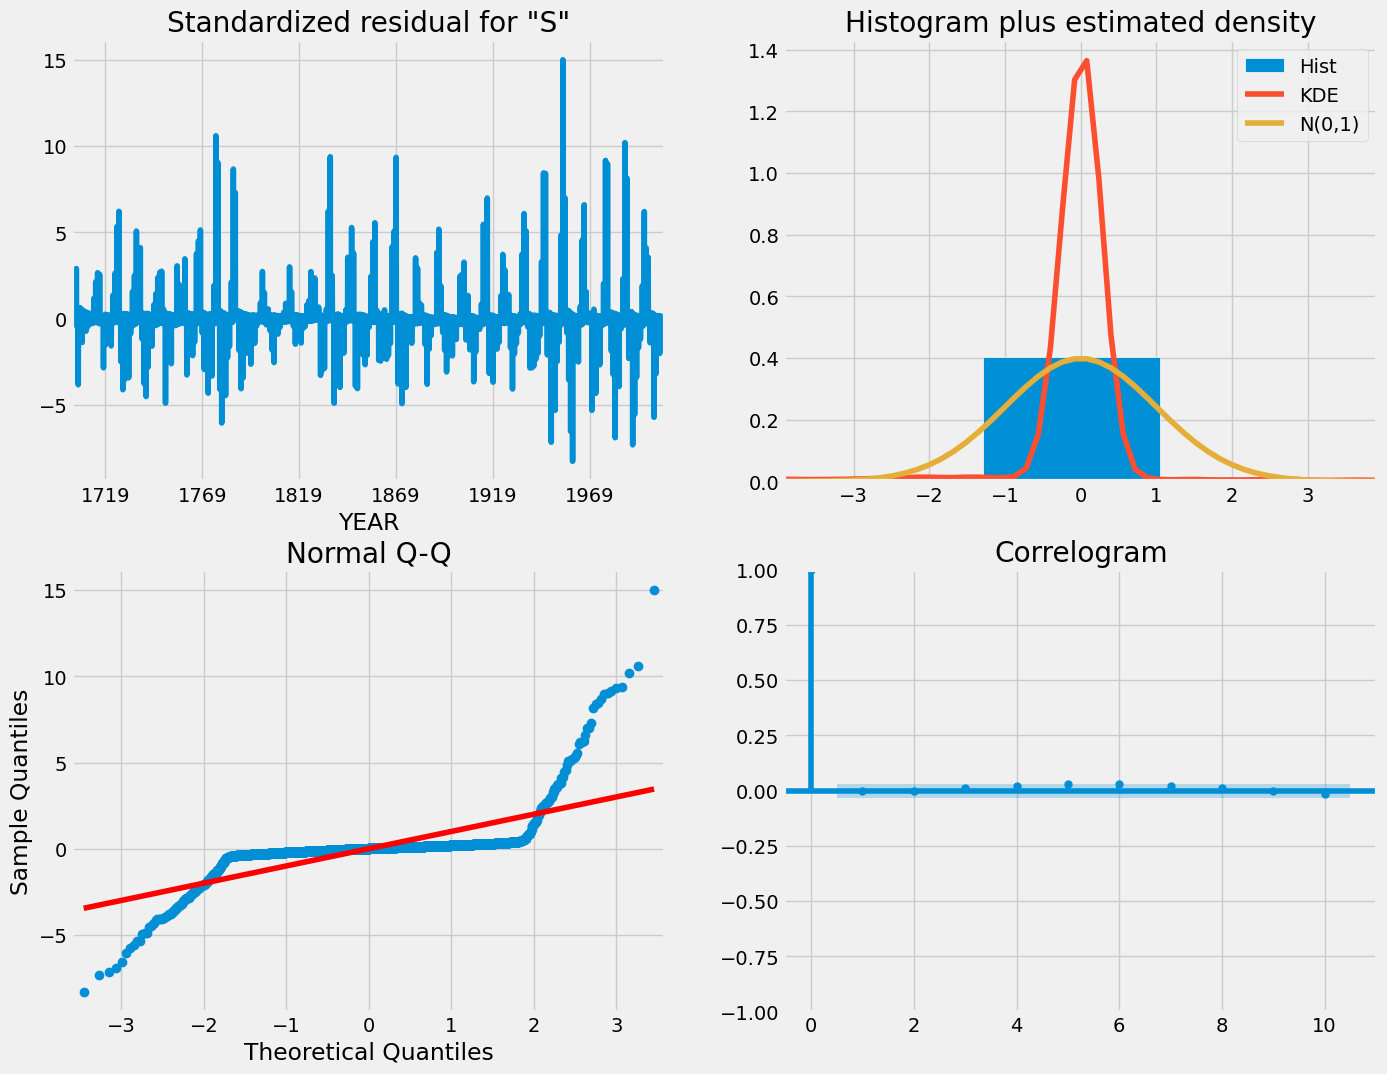

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [11]:
pred = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=False)
pred_ci = pred.conf_int()

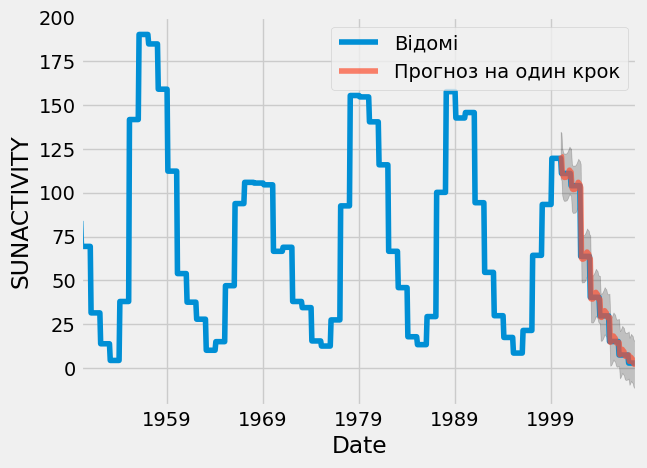

In [12]:
ax = y['1950':].plot(label='Відомі')
pred.predicted_mean.plot(ax=ax, label='Прогноз на один крок', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('SUNACTIVITY')
plt.legend()
plt.show()

In [13]:
y_forecasted = pred.predicted_mean
y_truth = y['2000-01-01':] # Обчислюємо середню квадртичну похибку
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Середня квадратна похибка прогнозів = {}'.format(round(mse, 2)))

Середня квадратна похибка прогнозів = 28.05


In [14]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2000-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

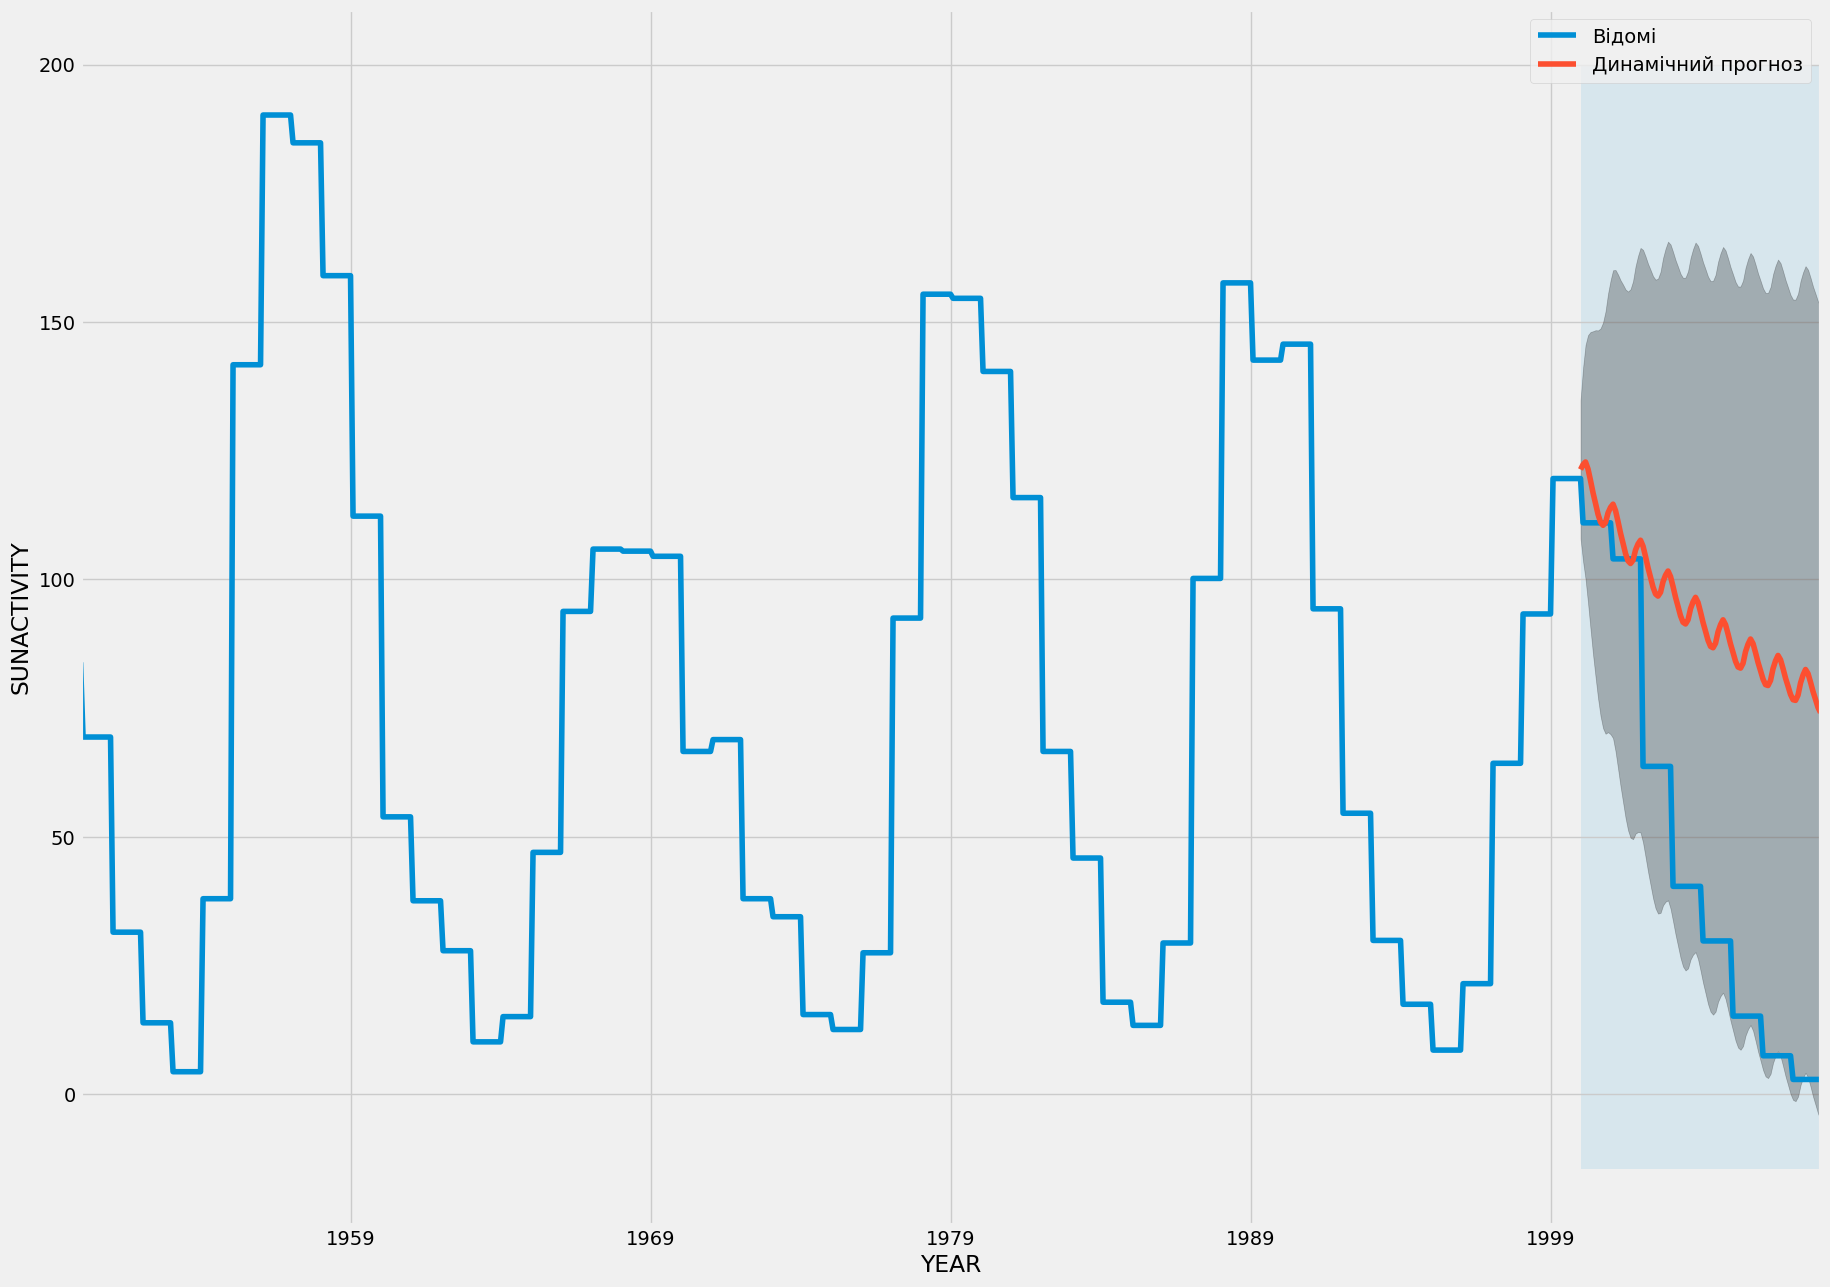

In [15]:
ax = y['1950':].plot(label='Відомі', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Динамічний прогноз', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
pred_dynamic_ci.iloc[:, 0],
pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2000-01-01'), y.index[-1],
alpha=.1, zorder=-1)
ax.set_xlabel('YEAR')
ax.set_ylabel('SUNACTIVITY')
plt.legend()
plt.show()

In [17]:
pred_uc = results.get_forecast(steps=300)
pred_ci = pred_uc.conf_int()

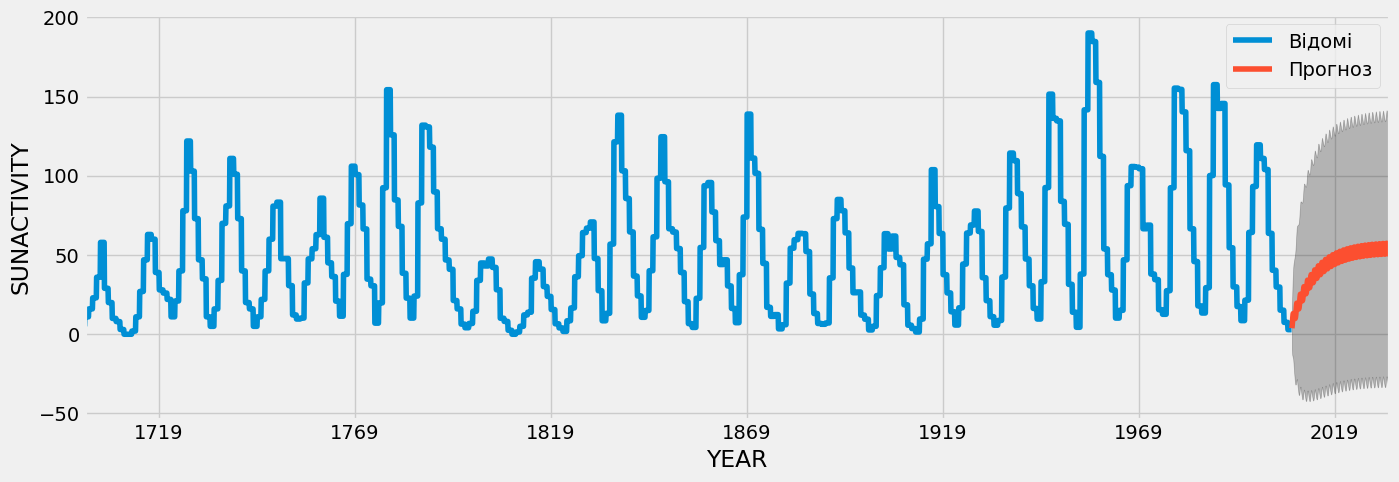

In [20]:
ax = y.plot(label='Відомі', figsize=(15, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('YEAR')
ax.set_ylabel('SUNACTIVITY')
plt.legend()
plt.show()

**Таким чином, враховуючи циклічність сонячної активності, для побудови прогнозної моделі у якості параметру для SARIMAX було визначено 11. Але у кінцевому підсумку параметри точності побудованої моделі не дозволяють обрати її для здійснення прогнозів.**